In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import cm
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Reshape, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Dropout  
from keras import initializers
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.optimizers import RMSprop
import tensorflow.keras as keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import layers
from keras import models
from tensorflow.keras import models
import os
import scipy

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



Num GPUs Available:  0


## Authors
* Martin Wegmann (martin.wegmann@giub.unibe.ch)
* Fernando Jaume Santero (fernando.jaume@unige.ch)

December 2022

Goal: To train a recurrent neural network for climate field reconstruction

This is a notebook to train **ONE** kind of neural network architecture (LSTM with one layer, 64 neurons and a 5% dropout rate) on **ONE** kind of training data set (MPI-GE) with a training sample size of 10000

### Read in Pseudo-Location data

In [4]:
df2 = pd.read_csv("/Volumes/SPARK/ISTI/EKF400_v1_assim_ISTI_less1831_smallest.txt", delimiter = " ")

df2

,Station ID,Var,Lon,Lat,fyr,lyr
11,USC00508503,temp2,-135.333298,57.049999,1828,1990
69,USC00226177,temp2,-91.340797,31.588900,1799,2005
125,USW00013880,temp2,-80.040298,32.898602,1823,2005
184,USW00014735,temp2,-73.809196,42.743099,1795,2005
245,IN020040900,temp2,80.182999,13.000000,1796,2005
246,IN024140300,temp2,88.333000,22.533001,1816,2005
263,RSM00022550,temp2,40.733101,64.500000,1813,2005
265,RSM00024959,temp2,129.716705,62.016701,1829,2005
273,RSM00030710,temp2,104.349998,52.266701,1820,2005
281,RSXLT181644,temp2,37.566700,55.750000,1779,2005


In [5]:
lats=df2.Lat.values
lons=df2.Lon.values

In [6]:
nlats=len(lats)
nlons=len(lons)

### Read in Gridded Data

In [7]:
save_folder="/Volumes/SPARK/ubelix_downloads/"

pathToMPIGE = '/Volumes/SPARK/mpi_ge/t2m/atmos/' 
pathToEKF = '/Volumes/SPARK/ekf400v2/ensmean/' 
 

In [8]:

ds1 = xr.open_dataset(pathToMPIGE+'tas_Amon_all_datapoints_anoms.nc') # this is a concatenated file of all MPI-GE members and all time steps, T2M anomalies
ds1_var=ds1.tas


ds2 = xr.open_dataset(pathToEKF + 'EKF400_ensmean_v2.0_t2m_anoms.nc')
ds2_var=ds2.air_temperature


In [9]:
lon_dim=ds1_var.shape[2]
lat_dim=ds1_var.shape[1]
print(lon_dim)
print(lat_dim)

192
96


In [10]:
latitudes=ds1_var.lat.values
longitudes=ds1_var.lon.values

### Convert latitude and longitude data of the stations to fit the grid

In [11]:
resolution_lon=360/lon_dim
print(resolution_lon)
resolution_lat=180/lat_dim
print(resolution_lat)
lats=df2.Lat.values
lons=df2.Lon.values
lons=(lons+180)/resolution_lon
lats=(lats-90)/(resolution_lat*-1)

1.875
1.875


In [12]:
# number of timesteps we have in the training data
timesteps_in_data=len(ds1_var.time.values)
timesteps_in_data # 100member*156years*12months

187200

In [13]:
# number of timesteps we want to reconstruct
timesteps_in_testdata=len(ds2_var.time.values)
timesteps_in_testdata

4824

### Set training sample size and amount of channels we want to train with

In [14]:
sample_size=10000
sample_size_plus_eval=int(sample_size+0.2*sample_size)
eval_timesteps=int(sample_size*0.2)
sample_size=sample_size_plus_eval
amount_locations=len(lats)
amount_channels=3

### Set output location and file name 

In [15]:
model="mpige"
member="01"
amount_locations=amount_locations
sample_size=sample_size
resolution="lowres"
output="anoms"


RNN1lstm_64_do005_path=os.path.join(save_folder, "best_model_64_do005" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_"+member+"_nonrandom.h5")
RNN1lstm_64_do005_path_nc=os.path.join(save_folder, "best_model_ekf400_64_do005_" + output + "_" + model + "_" + resolution +"_" +str(amount_locations) + "_" + str(sample_size) + "_RNN1lstm_"+member+"_nonrandom.nc")


### Define our Checkpoints

In [16]:
ess = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

mc_RNN1lstm_64_do005 = ModelCheckpoint(RNN1lstm_64_do005_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)




### Define our RNN models

In [17]:
input_shape=(amount_channels, amount_locations)
input_shape

(3, 25)

In [18]:
amount_locations

25

In [19]:
N1_lstm_64_do005= Sequential()
N1_lstm_64_do005.add(LSTM(64, input_shape=(amount_channels, amount_locations),dropout=0.05, activation='tanh', unroll=True))
#N1.add(Dense(256*512, activation='linear', bias_initializer=initializers. 􏰀→Constant(value=273.15)))
N1_lstm_64_do005.add(Dense(lat_dim*lon_dim, activation='linear')) 
N1_lstm_64_do005.add(Reshape((lat_dim,lon_dim)))
N1_lstm_64_do005.summary()

2022-12-20 19:12:25.038185: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 19:12:25.039817: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                23040     
_________________________________________________________________
dense_1 (Dense)              (None, 18432)             1198080   
_________________________________________________________________
reshape_1 (Reshape)          (None, 96, 192)           0         
Total params: 1,221,120
Trainable params: 1,221,120
Non-trainable params: 0
_________________________________________________________________


### Compile our RNN models

In [20]:

N1_lstm_64_do005.compile(keras.optimizers.Adam(1e-4), loss='mse',metrics=["mae"])



### Create our latitude and longitude channels

In [21]:
lon_points=lons
lat_points=lats

In [22]:
lat_points=np.array(lat_points,dtype=int)
lon_points=np.array(lon_points,dtype=int)

In [23]:
geo_locations_rand = np.random.rand(sample_size,1,nlons) 
geo_locations_zero = np.zeros_like(geo_locations_rand, dtype=np.float32)

geo_locations_rand_test = np.random.rand(timesteps_in_testdata,1,nlons) 
geo_locations_zero_test = np.zeros_like(geo_locations_rand_test, dtype=np.float32)

In [24]:
for i in range(0,timesteps_in_testdata):
    geo_locations_zero_test[i,0,:]=lon_points
lon_points_test=geo_locations_zero_test

In [25]:
for i in range(0,sample_size):
    geo_locations_zero[i,0,:]=lon_points
lon_points=geo_locations_zero

In [26]:
geo_locations_rand = np.random.rand(sample_size,1,nlats) 
geo_locations_zero = np.zeros_like(geo_locations_rand, dtype=np.float32)

geo_locations_rand_test = np.random.rand(timesteps_in_testdata,1,nlats) 
geo_locations_zero_test = np.zeros_like(geo_locations_rand_test, dtype=np.float32)

In [27]:
for i in range(0,timesteps_in_testdata):
    geo_locations_zero_test[i,0,:]=lat_points
lat_points_test=geo_locations_zero_test

In [28]:
for i in range(0,sample_size):
    geo_locations_zero[i,0,:]=lat_points
lat_points=geo_locations_zero

### create the time domain we want to sample

In [29]:
timesteps = np.random.randint(sample_size, size=(sample_size,1,1))
timesteps_nonrandom=list(range(0,sample_size))
sample_size

12000

In [30]:
all_timesteps_test=list(range(0,timesteps_in_testdata))
timesteps_in_testdata

4824

### sample our data according to the time domain

In [31]:
y1_array_nonrandom = ds1_var[timesteps_nonrandom,:,:] # selecting the time steps in the grid

In [34]:
y2_array_nonrandom = ds2_var[all_timesteps_test,:,:] # selecting the time steps in the grid



In [35]:
y1_matrix_nonrandom = y1_array_nonrandom.values.reshape((len(timesteps_nonrandom),ds1_var.shape[2]*ds1_var.shape[1])) # reshape to matrix, timesteps, lon*lat

y2_matrix_nonrandom = y2_array_nonrandom.values.reshape((len(all_timesteps_test),ds2_var.shape[2]*ds2_var.shape[1])) # reshape to matrix, timesteps, lon*lat

In [36]:
X1_nonrandom = np.zeros_like(lon_points, dtype=np.float32) # create zero matrix with structure like lon_points

In [41]:
X2_nonrandom = np.zeros_like(lon_points_test, dtype=np.float32) # create zero matrix with structure like lon_points

In [42]:
lat_points=np.array(lat_points,dtype=int)
lon_points=np.array(lon_points,dtype=int)

lat_points_test=np.array(lat_points_test,dtype=int)
lon_points_test=np.array(lon_points_test,dtype=int)

### sample our data according to the space domain

In [43]:
for i in range(len(timesteps_nonrandom)): 
        X1_nonrandom[i,0,:]=y1_matrix_nonrandom[i,lat_points[i,0,:]*lon_points[i,0,:]]

In [44]:
for i in range(len(all_timesteps_test)): 
        X2_nonrandom[i,0,:]=y2_matrix_nonrandom[i,lat_points_test[i,0,:]*lon_points_test[i,0,:]]

### normalize our data with the maximum values

In [45]:
lon_points_normmax=lon_points/lon_dim

lat_points_normmax=lat_points/lat_dim


In [46]:
lon_points_test_normmax=lon_points_test/lon_dim

lat_points_test_normmax=lat_points_test/lat_dim


In [47]:
X1_nonrandom_normmax=X1_nonrandom/X1_nonrandom.max()

In [48]:
X2_nonrandom_normmax=X2_nonrandom/X1_nonrandom.max()


In [49]:

y1_array_nonrandom_normmax=y1_array_nonrandom/y1_array_nonrandom.max()



y2_array_nonrandom_normax=y2_array_nonrandom/y1_array_nonrandom.max()

original=y2_array_nonrandom_normax

### concatenate our X or input data

In [50]:
#input_nn = np.concatenate((lat_points_normmax,lon_points_normmax,X1_normmax),axis=1)
# input_nn_test has a nonrandom time domain, so the same time structure as EKF400v2
input_nn_test = np.concatenate((lat_points_test_normmax,lon_points_test_normmax,X2_nonrandom_normmax),axis=1)

input_nn_nonrandom = np.concatenate((lat_points_normmax,lon_points_normmax,X1_nonrandom_normmax),axis=1)



input_nn = input_nn_nonrandom 

In [51]:
input_nn.shape

(12000, 3, 25)

In [52]:
input_nn_test.shape

(4824, 3, 25)

In [53]:
input_nn_train=input_nn[eval_timesteps:,:,:]
input_nn_val=input_nn[:eval_timesteps,:,:]

### define our Y or output data

In [54]:
y_values=y1_array_nonrandom_normmax.values

In [55]:
y_values_train=y_values[eval_timesteps:,:,:]

In [56]:
y_values_val=y_values[:eval_timesteps,:,:]

In [57]:
y_values_train.shape

(10000, 96, 192)

In [58]:
y_values_val.shape

(2000, 96, 192)

In [59]:
validation_data=(input_nn_val,y_values_val)

### train our models

In [60]:
history_N1_lstm_64_do005=N1_lstm_64_do005.fit(input_nn_train, y_values_train, batch_size=128, epochs=3000, verbose=1,validation_data=validation_data, callbacks=[ess, mc_RNN1lstm_64_do005])

Train on 10000 samples, validate on 2000 samples
Epoch 1/3000


2022-12-20 19:14:19.299614: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-20 19:14:19.303826: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-20 19:14:19.318889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] model_pruner failed: Invalid argument: MutableGraphView::MutableGraphView error: node 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat' has self cycle fanin 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat'.
2022-12-20 19:14:19.330723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: MutableGraphView::MutableGraphView error: node 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat' has self cycle fanin 'loss/reshape_1_loss/mean_s

 9984/10000 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0533

2022-12-20 19:14:25.986857: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-20 19:14:25.988441: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-12-20 19:14:25.993078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] model_pruner failed: Invalid argument: MutableGraphView::MutableGraphView error: node 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat' has self cycle fanin 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat'.
2022-12-20 19:14:25.998980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:502] remapper failed: Invalid argument: MutableGraphView::MutableGraphView error: node 'loss/reshape_1_loss/mean_squared_error/weighted_loss/concat' has self cycle fanin 'loss/reshape_1_loss/mean_s

10000/10000 [==============================] - 8s 803us/step - loss: 0.0070 - mae: 0.0532 - val_loss: 0.0070 - val_mae: 0.0531

Epoch 00001: val_loss improved from inf to 0.00697, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 2/3000
  384/10000 [>.............................] - ETA: 3s - loss: 0.0072 - mae: 0.0536

/Users/mwegmann/miniconda2/envs/temprec/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


10000/10000 [==============================] - 5s 477us/step - loss: 0.0069 - mae: 0.0529 - val_loss: 0.0069 - val_mae: 0.0529

Epoch 00002: val_loss improved from 0.00697 to 0.00692, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 3/3000
10000/10000 [==============================] - 5s 478us/step - loss: 0.0069 - mae: 0.0527 - val_loss: 0.0069 - val_mae: 0.0528

Epoch 00003: val_loss improved from 0.00692 to 0.00688, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 4/3000
10000/10000 [==============================] - 5s 486us/step - loss: 0.0068 - mae: 0.0526 - val_loss: 0.0068 - val_mae: 0.0527

Epoch 00004: val_loss improved from 0.00688 to 0.00683, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 5/3000
10000/10000 [==============================] - 5s

10000/10000 [==============================] - 8s 770us/step - loss: 0.0048 - mae: 0.0454 - val_loss: 0.0048 - val_mae: 0.0453

Epoch 00028: val_loss improved from 0.00478 to 0.00476, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 29/3000
10000/10000 [==============================] - 7s 679us/step - loss: 0.0047 - mae: 0.0453 - val_loss: 0.0047 - val_mae: 0.0452

Epoch 00029: val_loss improved from 0.00476 to 0.00474, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 30/3000
10000/10000 [==============================] - 6s 595us/step - loss: 0.0047 - mae: 0.0452 - val_loss: 0.0047 - val_mae: 0.0451

Epoch 00030: val_loss improved from 0.00474 to 0.00473, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 31/3000
10000/10000 [==============================] -

10000/10000 [==============================] - 7s 663us/step - loss: 0.0046 - mae: 0.0443 - val_loss: 0.0045 - val_mae: 0.0440

Epoch 00054: val_loss improved from 0.00455 to 0.00454, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 55/3000
10000/10000 [==============================] - 5s 511us/step - loss: 0.0046 - mae: 0.0443 - val_loss: 0.0045 - val_mae: 0.0440

Epoch 00055: val_loss improved from 0.00454 to 0.00454, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 56/3000
10000/10000 [==============================] - 5s 520us/step - loss: 0.0045 - mae: 0.0442 - val_loss: 0.0045 - val_mae: 0.0440

Epoch 00056: val_loss improved from 0.00454 to 0.00454, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 57/3000
10000/10000 [==============================] -

Epoch 82/3000
10000/10000 [==============================] - 5s 490us/step - loss: 0.0045 - mae: 0.0440 - val_loss: 0.0045 - val_mae: 0.0437

Epoch 00082: val_loss improved from 0.00449 to 0.00449, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 83/3000
10000/10000 [==============================] - 5s 521us/step - loss: 0.0045 - mae: 0.0440 - val_loss: 0.0045 - val_mae: 0.0437

Epoch 00083: val_loss improved from 0.00449 to 0.00449, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 84/3000
10000/10000 [==============================] - 5s 468us/step - loss: 0.0045 - mae: 0.0439 - val_loss: 0.0045 - val_mae: 0.0437

Epoch 00084: val_loss improved from 0.00449 to 0.00448, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 85/3000
10000/10000 [===================

10000/10000 [==============================] - 5s 451us/step - loss: 0.0045 - mae: 0.0438 - val_loss: 0.0045 - val_mae: 0.0435

Epoch 00111: val_loss did not improve from 0.00446
Epoch 112/3000
10000/10000 [==============================] - 5s 465us/step - loss: 0.0045 - mae: 0.0438 - val_loss: 0.0045 - val_mae: 0.0435

Epoch 00112: val_loss did not improve from 0.00446
Epoch 113/3000
10000/10000 [==============================] - 5s 466us/step - loss: 0.0045 - mae: 0.0438 - val_loss: 0.0045 - val_mae: 0.0435

Epoch 00113: val_loss improved from 0.00446 to 0.00446, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 114/3000
10000/10000 [==============================] - 5s 505us/step - loss: 0.0045 - mae: 0.0438 - val_loss: 0.0045 - val_mae: 0.0435

Epoch 00114: val_loss improved from 0.00446 to 0.00446, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_no

10000/10000 [==============================] - 5s 456us/step - loss: 0.0045 - mae: 0.0437 - val_loss: 0.0044 - val_mae: 0.0434

Epoch 00145: val_loss did not improve from 0.00445
Epoch 146/3000
10000/10000 [==============================] - 5s 460us/step - loss: 0.0045 - mae: 0.0437 - val_loss: 0.0044 - val_mae: 0.0434

Epoch 00146: val_loss improved from 0.00445 to 0.00445, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 147/3000
10000/10000 [==============================] - 5s 458us/step - loss: 0.0045 - mae: 0.0437 - val_loss: 0.0044 - val_mae: 0.0434

Epoch 00147: val_loss did not improve from 0.00445
Epoch 148/3000
10000/10000 [==============================] - 5s 492us/step - loss: 0.0045 - mae: 0.0437 - val_loss: 0.0044 - val_mae: 0.0434

Epoch 00148: val_loss improved from 0.00445 to 0.00444, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_no


Epoch 00177: val_loss did not improve from 0.00444
Epoch 178/3000
10000/10000 [==============================] - 5s 497us/step - loss: 0.0045 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00178: val_loss did not improve from 0.00444
Epoch 179/3000
10000/10000 [==============================] - 5s 451us/step - loss: 0.0044 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00179: val_loss did not improve from 0.00444
Epoch 180/3000
10000/10000 [==============================] - 5s 490us/step - loss: 0.0045 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00180: val_loss improved from 0.00444 to 0.00443, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 181/3000
10000/10000 [==============================] - 5s 488us/step - loss: 0.0045 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00181: val_loss did not improve from 0.00443
Epoch 182/3000
10000/10000 [===================

Epoch 213/3000
10000/10000 [==============================] - 5s 466us/step - loss: 0.0044 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00213: val_loss did not improve from 0.00443
Epoch 214/3000
10000/10000 [==============================] - 5s 528us/step - loss: 0.0044 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00214: val_loss did not improve from 0.00443
Epoch 215/3000
10000/10000 [==============================] - 5s 543us/step - loss: 0.0044 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00215: val_loss did not improve from 0.00443
Epoch 216/3000
10000/10000 [==============================] - 5s 472us/step - loss: 0.0045 - mae: 0.0436 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00216: val_loss improved from 0.00443 to 0.00443, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 217/3000
10000/10000 [==============================] - 4s 448us/step - loss: 0.0044 - mae: 0

10000/10000 [==============================] - 5s 510us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00251: val_loss did not improve from 0.00442
Epoch 252/3000
10000/10000 [==============================] - 5s 518us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00252: val_loss did not improve from 0.00442
Epoch 253/3000
10000/10000 [==============================] - 5s 506us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00253: val_loss improved from 0.00442 to 0.00442, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 254/3000
10000/10000 [==============================] - 5s 507us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00254: val_loss did not improve from 0.00442
Epoch 255/3000
10000/10000 [==============================] - 5s 511us/step - loss: 0.0044 - mae: 0.0435 - val_los

10000/10000 [==============================] - 5s 512us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00291: val_loss did not improve from 0.00442
Epoch 292/3000
10000/10000 [==============================] - 5s 520us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00292: val_loss did not improve from 0.00442
Epoch 293/3000
10000/10000 [==============================] - 5s 502us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00293: val_loss did not improve from 0.00442
Epoch 294/3000
10000/10000 [==============================] - 5s 533us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00294: val_loss did not improve from 0.00442
Epoch 295/3000
10000/10000 [==============================] - 5s 503us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00295: val_loss improved from 0.00442 to 0.00442, saving model to /Volumes/SPARK/ubelix_do

10000/10000 [==============================] - 5s 493us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00329: val_loss did not improve from 0.00442
Epoch 330/3000
10000/10000 [==============================] - 5s 508us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0433

Epoch 00330: val_loss did not improve from 0.00442
Epoch 331/3000
10000/10000 [==============================] - 5s 489us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00331: val_loss did not improve from 0.00442
Epoch 332/3000
10000/10000 [==============================] - 5s 484us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00332: val_loss improved from 0.00442 to 0.00442, saving model to /Volumes/SPARK/ubelix_downloads/best_model_64_do005anoms_mpige_lowres_25_12000_RNN1lstm_01_nonrandom.h5
Epoch 333/3000
10000/10000 [==============================] - 5s 517us/step - loss: 0.0044 - mae: 0.0435 - val_los

10000/10000 [==============================] - 5s 527us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00367: val_loss did not improve from 0.00441
Epoch 368/3000
10000/10000 [==============================] - 5s 532us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00368: val_loss did not improve from 0.00441
Epoch 369/3000
10000/10000 [==============================] - 5s 523us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00369: val_loss did not improve from 0.00441
Epoch 370/3000
10000/10000 [==============================] - 5s 535us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00370: val_loss did not improve from 0.00441
Epoch 371/3000
10000/10000 [==============================] - 5s 529us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00371: val_loss did not improve from 0.00441
Epoch 372/3000
10000/10000 [=================

10000/10000 [==============================] - 7s 687us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00407: val_loss did not improve from 0.00441
Epoch 408/3000
10000/10000 [==============================] - 7s 687us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00408: val_loss did not improve from 0.00441
Epoch 409/3000
10000/10000 [==============================] - 7s 712us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00409: val_loss did not improve from 0.00441
Epoch 410/3000
10000/10000 [==============================] - 6s 638us/step - loss: 0.0044 - mae: 0.0435 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00410: val_loss did not improve from 0.00441
Epoch 411/3000
10000/10000 [==============================] - 7s 741us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00411: val_loss did not improve from 0.00441
Epoch 412/3000
10000/10000 [=================

10000/10000 [==============================] - 6s 574us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00447: val_loss did not improve from 0.00441
Epoch 448/3000
10000/10000 [==============================] - 5s 532us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00448: val_loss did not improve from 0.00441
Epoch 449/3000
10000/10000 [==============================] - 6s 557us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00449: val_loss did not improve from 0.00441
Epoch 450/3000
10000/10000 [==============================] - 5s 513us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00450: val_loss did not improve from 0.00441
Epoch 451/3000
10000/10000 [==============================] - 5s 500us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00451: val_loss did not improve from 0.00441
Epoch 452/3000
10000/10000 [=================


Epoch 00486: val_loss did not improve from 0.00441
Epoch 487/3000
10000/10000 [==============================] - 5s 520us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00487: val_loss did not improve from 0.00441
Epoch 488/3000
10000/10000 [==============================] - 5s 526us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00488: val_loss did not improve from 0.00441
Epoch 489/3000
10000/10000 [==============================] - 5s 536us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00489: val_loss did not improve from 0.00441
Epoch 490/3000
10000/10000 [==============================] - 5s 536us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00490: val_loss did not improve from 0.00441
Epoch 491/3000
10000/10000 [==============================] - 5s 528us/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0432

Epoch 00491: val_loss did not

### Visualisation of training procedure

In [61]:
val_loss_list=[]
loss_list=[]

0.004407856728881597
0.004412905795127153


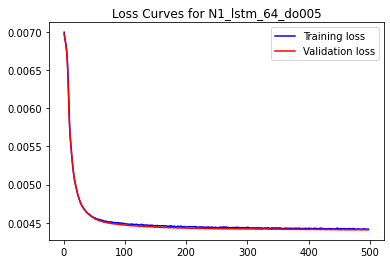

In [62]:
loss =history_N1_lstm_64_do005.history["loss"]
val_loss =history_N1_lstm_64_do005.history["val_loss"]
epochs=range(1,len(loss)+1)

print(np.min(val_loss))
val_loss_list.append(np.min(val_loss))

print(np.min(loss))
loss_list.append(np.min(loss))
plt.figure()

plt.plot(epochs,loss,"b",color="blue",label="Training loss")
plt.plot(epochs,val_loss,"b",color="red",label="Validation loss")
plt.title("Loss Curves for N1_lstm_64_do005")
plt.legend()
plt.show()

### Reconstruction

In [63]:
Est_RNN1_test_lstm_do005=N1_lstm_64_do005.predict(input_nn_test)
prediction=Est_RNN1_test_lstm_do005

In [64]:
unnormalize_nonrandom=y1_array_nonrandom.max().values

### lets have a look at our reconstruction/prediction

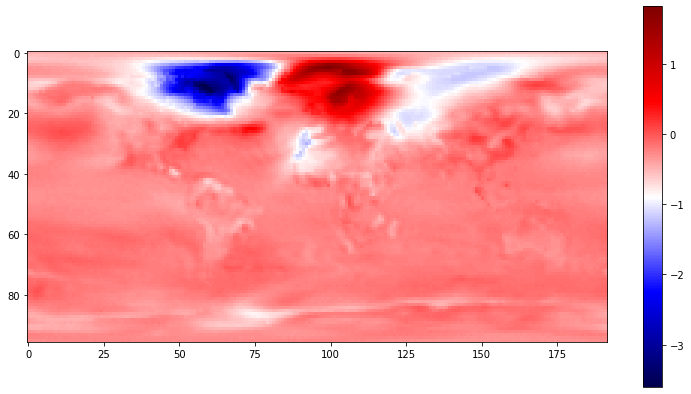

In [65]:
fig = plt.figure(figsize=(13, 7))
plt.imshow(prediction[0,:,:]*unnormalize_nonrandom, cmap='seismic',origin='upper',interpolation="none") 
plt.colorbar()

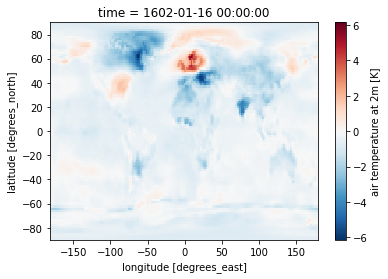

In [66]:
ds2_var.isel(time=0).plot()

From here on all kinds of error,correlation and EOF analysis can be done. 

Example for correlation analysis:

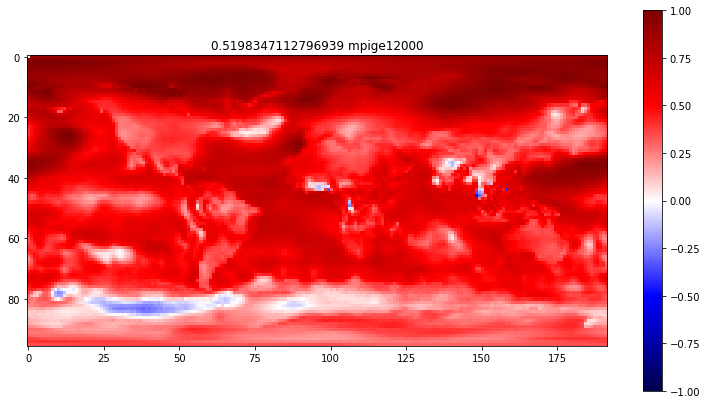

In [67]:
original_4_corr=original.values.reshape((original.shape[0],ds2_var.shape[2]*ds2_var.shape[1]))
prediction_4_corr=prediction.reshape((prediction.shape[0],ds2_var.shape[2]*ds2_var.shape[1]))

structure_dummy= np.arange(original_4_corr.shape[1], dtype=float)

for a in range(1,original_4_corr.shape[1]):
    one_R=np.corrcoef(prediction_4_corr[:,a], original_4_corr[:,a])
    structure_dummy[a]=one_R[0,1]
corr_matrix_prediction=structure_dummy.reshape(ds2_var.shape[1],ds2_var.shape[2])


fig = plt.figure(figsize=(13, 7))
plt.imshow(corr_matrix_prediction, vmin=-1, vmax=1, cmap='seismic',origin='upper',interpolation="none")
plt.title(str(np.mean(corr_matrix_prediction))+" "+model+str(sample_size))
plt.colorbar()

### save netcdf of reconstruction

In [ ]:
#!/usr/bin/env ipython
# ---------------------
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num
# -----------------------
ntimesteps = Est_N1_lstm_64_do005.shape[0];
nyears=int(ntimesteps/12)
nmonths=12
output=RNN1lstm_64_do005_path_nc 
unout = 'days since 1600-01-01 00:00:00'
# -----------------------
ny, nx = (lat_dim, lon_dim)
lon = longitudes
lat = latitudes


dataout = Est_N1_lstm_64_do005[:,:,:]*unnormalize_nonrandom; # create some random data
#datesout = [datetime.datetime(1601+years[iyear],months[iyear],1) for iyear in range(nyears)]; # create datevalues

datesout=[]
for iyear in range(nyears):
    for imonth in range(nmonths):
        datesout.append(datetime.datetime(1602+iyear,1+imonth,1))
#datesout = [datetime.datetime(1900+iyear,1,1) for iyear in range(nyears)]; # create datevalues

print(datesout[-1])
# =========================
ncout = Dataset(output,'w','NETCDF4'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',ntimesteps);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable("t2m",'float32',('time','lat','lon'));myvar.setncattr('units',"K");myvar[:] = dataout;
ncout.close();